# Load data

In [18]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'mat_del', 'pat_del',
                                   'no_mat_del', 'no_pat_del',
                                   'mom_del', 'dad_del'])


In [19]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [911]:
chrom = '22'
family_sizes = [3, 4, 5, 6]
phase_dir = '../phased'
data_dir = '../split_gen_miss'
#phase_dir = '../phased_ssc'
#data_dir = '../split_gen_miss_ssc'

In [912]:
# Pull cytogenetic coordinates
with open('../data/cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])

In [913]:
monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
#print(monozygotic_multiple_families)

In [969]:
import numpy as np

all_positions = set()
family_to_chroms = defaultdict(set)
chroms = [22]#range(1, 23)
for chrom in chroms:
    print(chrom)

    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    all_positions.add((chrom, start_pos))
                    all_positions.add((chrom, end_pos))
                    family_to_chroms[family_key].add(chrom)
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'family size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)
    
pos_to_index = dict([(x, i) for i, x in enumerate(sorted(all_positions))])
max_index = len(pos_to_index)

families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms) and k.split('.')[0] not in monozygotic_multiple_families])
#families_to_include = families_to_include & set(fams_with_many)
families_to_include = families_to_include - set(fams_with_many)
print('Num families included', len(families_to_include))


22
Num families included 784


In [970]:
from collections import defaultdict

# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()

fams = set()
for chrom in chroms:
    
    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                num_fams_of_size = 0
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include:
                        family_to_individuals[family_key] = pieces[1:(1+j)]
                        fams.add(family_key)
                        num_fams_of_size += 1
                print('Chrom %d: %d families of size %d' % (chrom, num_fams_of_size, j))

            # load deletions
            with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in family_key in families_to_include:
                        inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                        start_index, end_index = pos_to_index[(chrom, start_pos)], pos_to_index[(chrom, end_pos)]
                        length = end_pos - start_pos + 1
                        individuals = family_to_individuals[family_key]    

                        # deletion state of both parents must be known
                        #if inheritance_state[0]>=0 and inheritance_state[1]>=0 and inheritance_state[2]>=0 and inheritance_state[3]>=0:

                        doubledel, singledel, nodel = [], [], []
                        has_mat_del, has_pat_del = [], []
                        no_mat_del, no_pat_del = [], []

                        # children
                        for k, child_id in enumerate(individuals[2:]):
                            mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]

                            mat_del, pat_del = None, None
                            if mat >= 0 and inheritance_state[mat] >= 0:
                                mat_del = inheritance_state[mat]==0
                            elif mat == -1 and inheritance_state[0] == inheritance_state[1] and inheritance_state[0] >= 0:
                                mat_del = inheritance_state[0]==0

                            if pat >= 0 and inheritance_state[2+pat] >= 0:
                                pat_del = inheritance_state[2+pat]==0
                            elif pat == -1 and inheritance_state[2] == inheritance_state[3] and inheritance_state[2] >= 0:
                                pat_del = inheritance_state[2]==0
                                
                            if mat_del is not None and pat_del is not None:
                                if mat_del and pat_del:
                                    doubledel.append(child_id)
                                elif mat_del or pat_del:
                                    singledel.append(child_id)
                                else:
                                    nodel.append(child_id)

                            if mat_del is not None:
                                if mat_del:
                                    has_mat_del.append(child_id)
                                else:
                                    no_mat_del.append(child_id)

                            if pat_del is not None:
                                if pat_del:
                                    has_pat_del.append(child_id)
                                else:
                                    no_pat_del.append(child_id)

                        # decide how many deletions mom and dad have
                        mom_del, dad_del = None, None
                        if inheritance_state[0] == 0 and inheritance_state[1] == 0:
                            mom_del = 2
                        elif inheritance_state[0] == 0 or inheritance_state[1] == 0:
                            mom_del = 1
                        else:
                            mom_del = 0
                        if inheritance_state[2] == 0 and inheritance_state[3] == 0:
                            dad_del = 2
                        elif inheritance_state[2] == 0 or inheritance_state[3] == 0:
                            dad_del = 1
                        else:
                            dad_del = 0

                        deletions.append(Deletion(family_key, chrom,
                                                              start_pos, end_pos, start_index, end_index, length,
                                                              individuals[:2]+doubledel+singledel+nodel,
                                                              doubledel, singledel, nodel,
                                                              has_mat_del, has_pat_del, no_mat_del, no_pat_del, 
                                                              mom_del, dad_del))
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'fammily size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)
        
                
print('total families', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', len([x for x in deletions if x.mom_del is not None and x.mom_del > 0]), 
      'paternal', len([x for x in deletions if x.dad_del is not None and x.dad_del > 0]))



Chrom 22: 17 families of size 3
Chrom 22: 403 families of size 4
Chrom 22: 317 families of size 5
Chrom 22: 47 families of size 6
total families 784
deletions 15090 maternal 286 paternal 319


In [971]:
from scipy.stats import chi2_contingency, fisher_exact

print('Maternal vs Paternal')
c = [[sum([len(x.mat_del) for x in deletions if x.mom_del == 1]), sum([len(x.no_mat_del) for x in deletions if x.mom_del == 1])], 
     [sum([len(x.pat_del) for x in deletions if x.dad_del == 1]), sum([len(x.pat_del) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Female vs Male')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2']) for x in deletions if x.dad_del == 1])], 
     [sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Autistic vs Typical')
c = [[sum([len([y for y in x.mat_del if child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])], 
     [sum([len([y for y in x.mat_del if child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Females: Autistic vs Typical')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])], 
     [sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Males: Autistic vs Typical')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])], 
     [sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Autistic: Female vs Male')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])], 
     [sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Typical: Female vs Male')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])], 
     [sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]), 
     sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Autistic Females: Maternal vs Paternal')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1]), 
      sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])],
      [sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]), 
      sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Autistic Males: Maternal vs Paternal')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1]), 
      sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])],
      [sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]), 
      sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Typical Females: Maternal vs Paternal')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1]), 
      sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])],
      [sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]), 
      sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

print('Typical Males: Maternal vs Paternal')
c = [[sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1]), 
      sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])],
      [sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]), 
      sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])]]
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=True)[1])
print()

Maternal vs Paternal
ratios 0.592 0.500
pvalue 0.00018694672443180082

Female vs Male
ratios 0.586 0.600
pvalue 0.6445956827058164

Autistic vs Typical
ratios 0.613 0.525
pvalue 0.006534896721042079

Females: Autistic vs Typical
ratios 0.619 0.527
pvalue 0.06507710202022818

Males: Autistic vs Typical
ratios 0.611 0.523
pvalue 0.06474912726982913

Autistic: Female vs Male
ratios 0.619 0.611
pvalue 0.8509581138246372

Typical: Female vs Male
ratios 0.527 0.523
pvalue 0.9648484611330502

Autistic Females: Maternal vs Paternal
ratios 0.601 0.635
pvalue 0.6271897658762181

Autistic Males: Maternal vs Paternal
ratios 0.621 0.602
pvalue 0.5768100479000808

Typical Females: Maternal vs Paternal
ratios 0.494 0.560
pvalue 0.4881272420335515

Typical Males: Maternal vs Paternal
ratios 0.463 0.564
pvalue 0.3337399449825794



In [972]:
from scipy.stats import binom

def calc_binom_pvalue(k, n):
    if n == 0:
        return 1
    elif k/n < 0.5:
        return 2*binom.cdf(k, n, 0.5)
    elif k/n > 0.5:
        return 2*(binom.sf(k, n, 0.5) + binom.pmf(k, n, 0.5))
    else:
        return 1

#print(calc_binom_pvalue(10, 10))
#print(calc_binom_pvalue(5, 10))
#print(calc_binom_pvalue(0, 10))

print('Imbalanced Transmission')
trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])
notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]) 
print('Autistic Female', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)

trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])
notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]) 
print('Typical Female', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)   

trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1])
notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1]) 
print('Autistic Male', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)

trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1])
notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1]) 
print('Typical Male', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans) 

Imbalanced Transmission
Autistic Female 0.619 4.0669180048943257e-05 302
Typical Female 0.527 0.5360050623796432 167
Autistic Male 0.611 5.655102992146444e-12 964
Typical Male 0.523 0.6635853603383775 132


In [973]:
af_p, tf_p, am_p, tm_p = [], [], [], []
af_s, tf_s, am_s, tm_s = [], [], [], []

a_p, t_p, m_p, f_p = [], [], [], []
a_s, t_s, m_s, f_s = [], [], [], []
for chrom in chroms:
    print(chrom)
    trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    af_p.append(calc_binom_pvalue(trans, trans+notrans))
    af_s.append(1 if trans>notrans else -1)
    #print('Autistic Female', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)

    trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    tf_p.append(calc_binom_pvalue(trans, trans+notrans))
    tf_s.append(1 if trans>notrans else -1)
    #print('Typical Female', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)   

    trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    am_p.append(calc_binom_pvalue(trans, trans+notrans))
    am_s.append(1 if trans>notrans else -1)
    #print('Autistic Male', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)

    trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1' and child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    tm_p.append(calc_binom_pvalue(trans, trans+notrans))
    tm_s.append(1 if trans>notrans else -1)
    #print('Typical Male', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans) 
    
    trans = sum([len([y for y in x.mat_del if child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_affected[y] == '2']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_affected[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    a_p.append(calc_binom_pvalue(trans, trans+notrans))
    a_s.append(1 if trans>notrans else -1)
    #print('Autistic', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)

    trans = sum([len([y for y in x.mat_del if child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_affected[y] == '1']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_affected[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    t_p.append(calc_binom_pvalue(trans, trans+notrans))
    t_s.append(1 if trans>notrans else -1)
    #print('Typical', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans) 
    
    trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '1' ]) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '1']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '1']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    m_p.append(calc_binom_pvalue(trans, trans+notrans))
    m_s.append(1 if trans>notrans else -1)
    #print('Male', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)

    trans = sum([len([y for y in x.mat_del if child_id_to_sex[y] == '2' ]) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.pat_del if child_id_to_sex[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom])
    notrans = sum([len([y for y in x.no_mat_del if child_id_to_sex[y] == '2']) for x in deletions if x.mom_del == 1 and x.chrom == chrom])+sum([len([y for y in x.no_pat_del if child_id_to_sex[y] == '2']) for x in deletions if x.dad_del == 1 and x.chrom == chrom]) 
    f_p.append(calc_binom_pvalue(trans, trans+notrans))
    f_s.append(1 if trans>notrans else -1)
    #print('Female', '%0.3f'%(trans/(trans+notrans)), calc_binom_pvalue(trans, trans+notrans), trans+notrans)

    

22


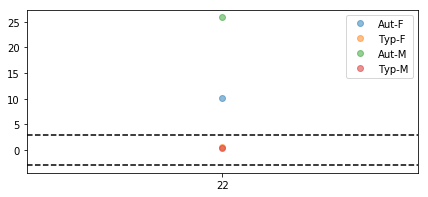

In [974]:
plt.figure(figsize=(7, 3))
plt.plot(chroms, -np.log(af_p)*af_s, 'o', alpha=0.5, label='Aut-F')
plt.plot(chroms, -np.log(tf_p)*tf_s, 'o', alpha=0.5, label='Typ-F')
plt.plot(chroms, -np.log(am_p)*am_s, 'o', alpha=0.5, label='Aut-M')
plt.plot(chroms, -np.log(tm_p)*tm_s, 'o', alpha=0.5, label='Typ-M')

plt.axhline(-np.log(0.05/len(chroms)), color='black', linestyle='--')
plt.axhline(np.log(0.05/len(chroms)), color='black', linestyle='--')

plt.legend()
plt.xticks(chroms)
plt.show()

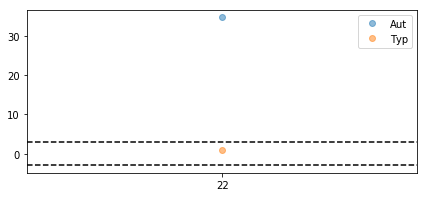

In [975]:
plt.figure(figsize=(7, 3))
plt.plot(chroms, (-np.log(a_p)*a_s), 'o', alpha=0.5, label='Aut')
plt.plot(chroms, (-np.log(t_p)*t_s), 'o', alpha=0.5, label='Typ')

plt.axhline(-np.log(0.05/len(chroms)), color='black', linestyle='--')
plt.axhline(np.log(0.05/len(chroms)), color='black', linestyle='--')

plt.legend()
plt.xticks(chroms)
plt.show()

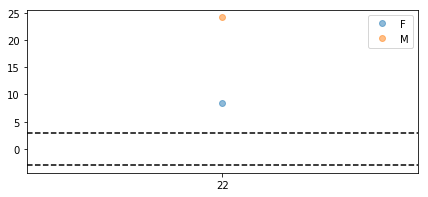

In [976]:
plt.figure(figsize=(7, 3))
plt.plot(chroms, (-np.log(f_p)*f_s), 'o', alpha=0.5, label='F')
plt.plot(chroms, (-np.log(m_p)*m_s), 'o', alpha=0.5, label='M')

plt.axhline(-np.log(0.05/len(chroms)), color='black', linestyle='--')
plt.axhline(np.log(0.05/len(chroms)), color='black', linestyle='--')

plt.legend()
plt.xticks(chroms)
plt.show()


Imbalanced Transmission Opportunities
Autistic Female nan (nan, nan)
Typical Female nan (nan, nan)
Autistic Male nan (nan, nan)
Typical Male nan (nan, nan)



//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log
//anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
//anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
//anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
//anaconda/lib/python3.6/site-packages/matplot

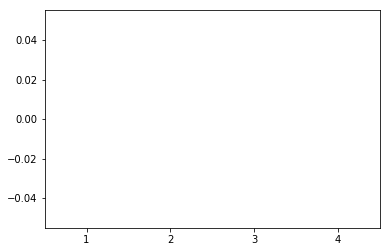

Family size 3 0.412 0.150 (0.09384004447950917, 0.7296893672851967)
Family size 4 0.622 0.082 (0.4603903859309953, 0.782852857312248)
Family size 5 0.850 0.090 (0.6713099271126122, 1.028036478116146)
Family size 6 1.170 0.138 (0.8955971943232521, 1.4436885199624623)


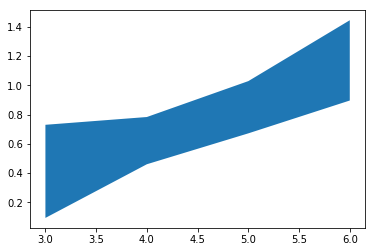

In [952]:
import scipy.stats as st

child_id_to_family_size = dict()
for inds in family_to_individuals.values():
    for child in inds[2:]:
        child_id_to_family_size[child] = len(inds)
        
child_id_to_transop = defaultdict(int)
child_id_to_transop_len = defaultdict(int)
for d in deletions:
    if d.mom_del == 1:
        for child in d.individuals[2:]:
            child_id_to_transop[child] += 1
            child_id_to_transop_len[child] += d.length
    if d.dad_del == 1:
        for child in d.individuals[2:]:
            child_id_to_transop[child] += 1
            child_id_to_transop_len[child] += d.length
            
print('\nImbalanced Transmission Opportunities')
all_children = sum([x[2:] for x in family_to_individuals.values()], [])

bp_data = []
conf = []
a = [child_id_to_transop_len[x] for x in all_children if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2']
a = np.log(np.asarray(a)+1)
bp_data.append(a)
if len(a) > 0:
    conf.append(st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
else:
    conf.append((np.nan, np.nan))
print('Autistic Female', '%0.3f'%(0 if len(a) == 0 else np.mean(a)), conf[0])
    
a = [child_id_to_transop_len[x] for x in all_children if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1']
a = np.log(np.asarray(a)+1)
bp_data.append(a)
if len(a) > 0:
    conf.append(st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
else:
    conf.append((np.nan, np.nan))
print('Typical Female', '%0.3f'%(0 if len(a) == 0 else np.mean(a)), conf[1])
  
a = [child_id_to_transop_len[x] for x in all_children if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2']
a = np.log(np.asarray(a)+1)
bp_data.append(a)
if len(a) > 0:
    conf.append(st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
else:
    conf.append((np.nan, np.nan))
print('Autistic Male', '%0.3f'%(0 if len(a) == 0 else np.mean(a)), conf[2])
    
a = [child_id_to_transop_len[x] for x in all_children if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1']
a = np.log(np.asarray(a)+1)
bp_data.append(a)
if len(a) > 0:
    conf.append(st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
else:
    conf.append((np.nan, np.nan))
print('Typical Male', '%0.3f'%(0 if len(a) == 0 else np.mean(a)), conf[3])
print()

plt.boxplot(bp_data)
plt.fill_between(range(1, 5), [x[0] for x in conf], [x[1] for x in conf])
#plt.ylim([0, 60])
plt.show()

conf = []
for famsize in family_sizes:
    a = [child_id_to_transop[x] for x in all_children if child_id_to_family_size[x] == famsize]
    if len(a) > 0:
        conf.append(st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
    else:
        conf.append((np.nan, np.nan))
    print('Family size', famsize, 
          '%0.3f'%(0 if len(a) == 0 else np.mean(a)),
         '%0.3f'%(0 if len(a) == 0 else st.sem(a)),
         conf[-1])
    
plt.fill_between(family_sizes, [x[0] for x in conf], [x[1] for x in conf])
plt.show()

In [953]:
import math

# deletions per family
fam_to_num_deletions = defaultdict(int)
fam_to_num_bases = defaultdict(int)
for d in deletions:
    if d.mom_del == 1:
        fam_to_num_deletions[(d.family, 'm')] += 1
        fam_to_num_bases[(d.family, 'm')] += d.length
        fam_to_num_bases[(d.family, 'a')] += d.length
    if d.dad_del == 1:
        fam_to_num_deletions[(d.family, 'd')] += 1
        fam_to_num_bases[(d.family, 'd')] += d.length
        fam_to_num_bases[(d.family, 'a')] += d.length


min length 0 max length 6 avg 0.38529411764705884 median 0.0


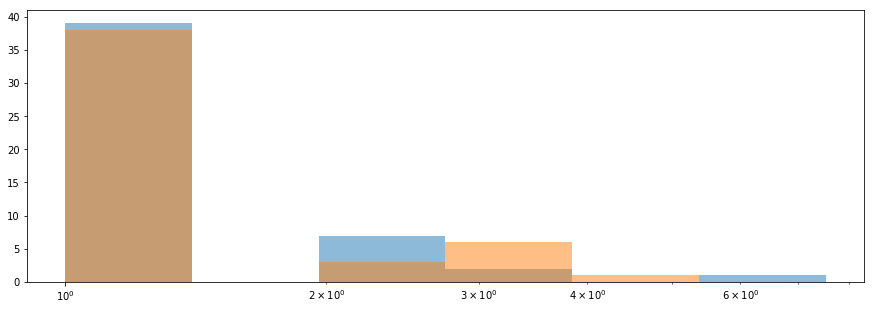

In [954]:
plt.figure(figsize=(15, 5))
base = 1.4



#fams_to_include2 = [k for k in fams if fam_to_num_deletions[(k, 'm')]<75 and fam_to_num_deletions[(k, 'd')]<75]
fams_to_include2 = fams
fams_with_many = [k for k in fams if fam_to_num_deletions[(k, 'm')]>=75 and fam_to_num_deletions[(k, 'd')]>=75]


all_num_del = [fam_to_num_deletions[(k, 'm')] for k in fams_to_include2] + [fam_to_num_deletions[(k, 'd')] for k in fams_to_include2]
max_length = max(all_num_del) 
min_length = min(all_num_del) 
mean_length = np.mean(all_num_del)
median_length = np.median(all_num_del)
print('min length', min_length, 'max length', max_length, 'avg', mean_length, 'median', median_length)
plt.hist([fam_to_num_deletions[(k, 'm')] for k in fams_to_include2], label='maternal', bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.hist([fam_to_num_deletions[(k, 'd')] for k in fams_to_include2], label='paternal', bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")

plt.show()

In [955]:
print('\n'.join(fams_with_many))
print('\n'.join(['%d %s' % (len(family_to_individuals[f]), f) for f in fams_with_many if f in family_to_individuals]))
                 
                 
                 

In [956]:
plt.figure(figsize=(15, 5))
base = 1.4

all_num_del = [fam_to_num_bases[(k, 'm')] for k in fams_to_include2] + [fam_to_num_bases[(k, 'd')] for k in fams_to_include2]
max_length = max(all_num_del) 
min_length = min(all_num_del) 
mean_length = np.mean(all_num_del)
median_length = np.median(all_num_del)
print('min length', min_length, 'max length', max_length, 'avg', mean_length, 'median', median_length)

plt.hist([fam_to_num_bases[(k, 'm')] for k in fams_to_include2], label='maternal', bins=[pow(base, i) for i in range(math.ceil(math.log(min_length, base)), math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.hist([fam_to_num_bases[(k, 'd')] for k in fams_to_include2], label='paternal', bins=[pow(base, i) for i in range(math.ceil(math.log(min_length, base)), math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")

plt.show()

min length -148826461 max length 0 avg -11200965.761764705 median 0.0


ValueError: math domain error

In [957]:
plt.figure(figsize=(15, 5))
base = 1.4
max_length = max(fam_to_num_bases.values()) 
min_length = min(fam_to_num_bases.values())
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]

print('min length', min_length, 'max length', max_length, 'avg', np.mean(list(fam_to_num_bases.values())), 'median', np.median(list(fam_to_num_bases.values())))
plt.hist([v for k, v in fam_to_num_bases.items() if k[1] == 'a'], bins=bins, alpha=0.5)

plt.gca().set_xscale("log")

plt.show()

ValueError: math domain error

[(nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (0.7544186046511628, 0.8055813953488372)]


<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

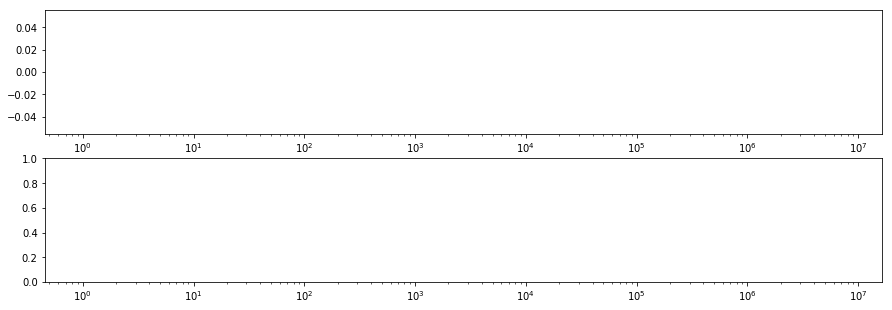

In [958]:
import numpy as np, scipy.stats as st

#bins = [1, 11000, 140000, 1100000, 10000000, 1000000000]

def calc_binom_conf(k, n):
    up, lo = binom.interval(0.95, n, k/n)
    return ((up-1)/n, (lo+1)/n)

binnedfam_aut = [0]*len(bins)
binnedfam_typ = [0]*len(bins)
fams = [k for k, v in fam_to_num_bases.items()]
dels = [fam_to_num_bases[k] for k in fams]
bin_indices = np.searchsorted(bins, dels)-1

for (fam, m), ind in zip(fams, bin_indices):
    if fam in family_to_individuals:
        children = family_to_individuals[fam][2:]
        binnedfam_aut[ind] += len([x for x in children if child_id_to_affected[x]=='2'])
        binnedfam_typ[ind] += len([x for x in children if child_id_to_affected[x]=='1'])

conf = []
for a, t in zip(binnedfam_aut, binnedfam_typ):
    if a+t == 0:
        conf.append((np.nan, np.nan))
    else:
        calc_binom_conf
        conf.append(calc_binom_conf(a, a+t))
        
print(conf)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(2, 1, 1)
plt.hist([v for k, v in fam_to_num_bases.items()], bins=bins, alpha=0.5)

plt.subplot(2, 1, 2, sharex=ax1)
plt.fill_between(bins, [c[0] for c in conf], [c[1] for c in conf], alpha=0.5)
plt.plot(bins, [np.nan if a+t==0 else a/(a+t) for a, t in zip(binnedfam_aut, binnedfam_typ)])
plt.gca().set_xscale("log")
plt.ylim([0, 1])
plt.show()

In [959]:
from numpy.polynomial.polynomial import polyfit

plt.figure(figsize=(7, 7))

fam_percaut, fam_matdel, fam_patdel = [], [], []
for fam, individuals in family_to_individuals.items():
    if fam_to_num_bases[(fam, 'm')]>0 and fam_to_num_bases[(fam, 'd')]>0 and len(individuals)>3:
        fam_percaut.append(len([x for x in individuals[2:] if child_id_to_affected[x]=='2'])/len(individuals[2:]))
        fam_matdel.append(fam_to_num_bases[(fam, 'm')])
        fam_patdel.append(fam_to_num_bases[(fam, 'd')])
    
plt.scatter(fam_percaut, np.log(fam_matdel), label='maternal', alpha=0.5)
#plt.hexbin(fam_percaut, np.log(fam_matdel), gridsize=50)

# Fit with polyfit
b, m = polyfit(fam_percaut, np.log(fam_matdel), 1)
print(b, m)
plt.plot(fam_percaut, b + (m * np.asarray(fam_percaut)), '-', alpha=0.5)

plt.scatter(fam_percaut, np.log(fam_patdel), label='paternal', alpha=0.5)
#plt.hexbin(fam_percaut, np.log(fam_patdel), gridsize=50)

# Fit with polyfit
b, m = polyfit(fam_percaut, np.log(fam_patdel), 1)
print(b, m)
plt.plot(fam_percaut, b + (m * np.asarray(fam_percaut)), '-', alpha=0.5)

plt.show()
    

TypeError: expected non-empty vector for x

# Analyze relationship between deletions and disease
We're going to look at both deletion status (DEL) as well as deletion transmission disequilibrium (TDT) and parental differences (PAR) as a baseline.

In [960]:
# Create contingency tables for each comparison

family_to_has_aff_and_unaff = dict()
for famkey, inds in family_to_individuals.items():
    has_aff_child = len([x for x in inds[2:] if child_id_to_affected[x] == '2']) > 0
    has_unaff_child = len([x for x in inds[2:] if child_id_to_affected[x] == '1']) > 0
    
    family_to_has_aff_and_unaff[famkey] = has_aff_child and has_unaff_child
    
print(sum(family_to_has_aff_and_unaff.values()), len(family_to_has_aff_and_unaff)-sum(family_to_has_aff_and_unaff.values()))

# position, has_del, is_affected, is_male, is_pat
# for del, only consider families with at least one affected and one unaffected child
del_conting_t = np.zeros((max_index, 2, 2, 2, 2), dtype=int)
tdt_conting_t = np.zeros((max_index, 2, 2, 2, 2), dtype=int)
par_conting_t = np.zeros((max_index, 3, 2), dtype=int)

for d in deletions:
    # DEL
    #if family_to_has_aff_and_unaff[d.family]:
    for x in d.doubledel:
        is_male = int(child_id_to_sex[x] == '1')
        is_affected = int(child_id_to_affected[x] == '2')
            
        del_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 0] += 1
        del_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 1] += 1
    for x in d.singledel:
        is_male = int(child_id_to_sex[x] == '1')
        is_affected = int(child_id_to_affected[x] == '2')
        is_pat = int(x in d.pat_del)
            
        del_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, is_pat] += 1
        del_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 1-is_pat] += 1
            
    for x in d.nodel:
        is_male = int(child_id_to_sex[x] == '1')
        is_affected = int(child_id_to_affected[x] == '2')
            
        del_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 0] += 1
        del_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 1] += 1
        
    # PAR
    if d.mom_del is not None:
        par_conting_t[d.start_index:(d.end_pos+1), d.mom_del, 0] += 1
    if d.dad_del is not None:
        par_conting_t[d.start_index:(d.end_pos+1), d.dad_del, 1] += 1
    
    # TDT
    if d.mom_del == 1:
        # mom
        for x in d.mat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 0] += 1
        
        for x in d.no_mat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 0] += 1
            
    if d.dad_del == 1:
        # dad
        for x in d.pat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 1, is_affected, is_male, 1] += 1
        
        for x in d.no_pat_del:
            is_male = int(child_id_to_sex[x] == '1')
            is_affected = int(child_id_to_affected[x] == '2')
            
            tdt_conting_t[d.start_index:(d.end_index+1), 0, is_affected, is_male, 1] += 1
    
total_affected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] == '2']) for individuals in family_to_individuals.values()])
total_unaffected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] != '2']) for individuals in family_to_individuals.values()])
print('total affected', total_affected, 'total unaffected', total_unaffected)

total_families = len(family_to_individuals)
print('total families', total_families)


76 94
total affected 338 total unaffected 92
total families 170


In [961]:
# find indices of changes
indices = set(np.where(np.any(par_conting_t[1:, :, :] != par_conting_t[:-1, :, :], axis=(1, 2)))[0])
indices = indices | set(np.where(np.any(del_conting_t[1:, :, :, :, :] != del_conting_t[:-1, :, :, :, :], axis=(1, 2, 3, 4)))[0])
indices = indices | set(np.where(np.any(tdt_conting_t[1:, :, :, :] != tdt_conting_t[:-1, :, :, :], axis=(1, 2, 3)))[0])
indices = np.asarray(sorted(indices))



In [962]:
print(indices.shape)

(2455,)


In [963]:
from scipy.stats import chi2_contingency, fisher_exact

# calculate pvalues for every point
del_pvalues = np.ones((max_index,))
del_male_pvalues = np.ones((max_index,))
del_female_pvalues = np.ones((max_index,))
del_mat_pvalues = np.ones((max_index,))
del_pat_pvalues = np.ones((max_index,))

tdt_pvalues = np.ones((max_index,))
tdt_male_pvalues = np.ones((max_index,))
tdt_female_pvalues = np.ones((max_index,))
tdt_mat_pvalues = np.ones((max_index,))
tdt_pat_pvalues = np.ones((max_index,))

del_male_pat_pvalues = np.ones((max_index,))
del_male_mat_pvalues = np.ones((max_index,))
del_female_pat_pvalues = np.ones((max_index,))
del_female_mat_pvalues = np.ones((max_index,))

tdt_male_pat_pvalues = np.ones((max_index,))
tdt_male_mat_pvalues = np.ones((max_index,))
tdt_female_pat_pvalues = np.ones((max_index,))
tdt_female_mat_pvalues = np.ones((max_index,))

par_pvalues = np.ones((max_index,))

num_tests = 0

for dc_t, p in [(np.sum(del_conting_t, axis=(3, 4)), del_pvalues),
              (np.sum(del_conting_t, axis=4)[:, :, 0], del_female_pvalues),
              (np.sum(del_conting_t, axis=4)[:, :, 1], del_male_pvalues),
              (np.sum(del_conting_t, axis=3)[:, :, 0], del_mat_pvalues),
              (np.sum(del_conting_t, axis=3)[:, :, 1], del_pat_pvalues),
              (np.sum(tdt_conting_t, axis=(3, 4)), tdt_pvalues),
              (np.sum(tdt_conting_t, axis=4)[:, :, 0], tdt_female_pvalues),
              (np.sum(tdt_conting_t, axis=4)[:, :, 1], tdt_male_pvalues),
              (np.sum(tdt_conting_t, axis=3)[:, :, 0], tdt_mat_pvalues),
              (np.sum(tdt_conting_t, axis=3)[:, :, 1], tdt_pat_pvalues),
              (par_conting_t, par_pvalues),
              (del_conting_t[:, :, 0, 0], del_female_mat_pvalues),
              (del_conting_t[:, :, 0, 1], del_female_pat_pvalues),
              (del_conting_t[:, :, 1, 0], del_male_mat_pvalues),
              (del_conting_t[:, :, 1, 1], del_male_pat_pvalues),
              (tdt_conting_t[:, :, 0, 0], tdt_female_mat_pvalues),
              (tdt_conting_t[:, :, 0, 1], tdt_female_pat_pvalues),
              (tdt_conting_t[:, :, 1, 0], tdt_male_mat_pvalues),
              (tdt_conting_t[:, :, 1, 1], tdt_male_pat_pvalues),
             ]:
    prev_i = 0
    for i in indices:
        dc = dc_t[i, :, :]

        # get rid of 0 rows/columns
        dc = dc[np.ix_(np.sum(dc, axis=1)>0, np.sum(dc, axis=0)>0)]        

        # calculate pvalue
        if dc.shape[0] > 1 and dc.shape[1] > 1:
            pvalue = chi2_contingency(dc, correction=True)[1]
            num_tests += 1
        #elif dc_t[i, :, :].shape == (2, 2):
        #    pvalue = fisher_exact(dc_t[i, :, :])[1]
        else:
            pvalue = 1
        p[prev_i:i] = pvalue
        prev_i = i
print(num_tests)

2437


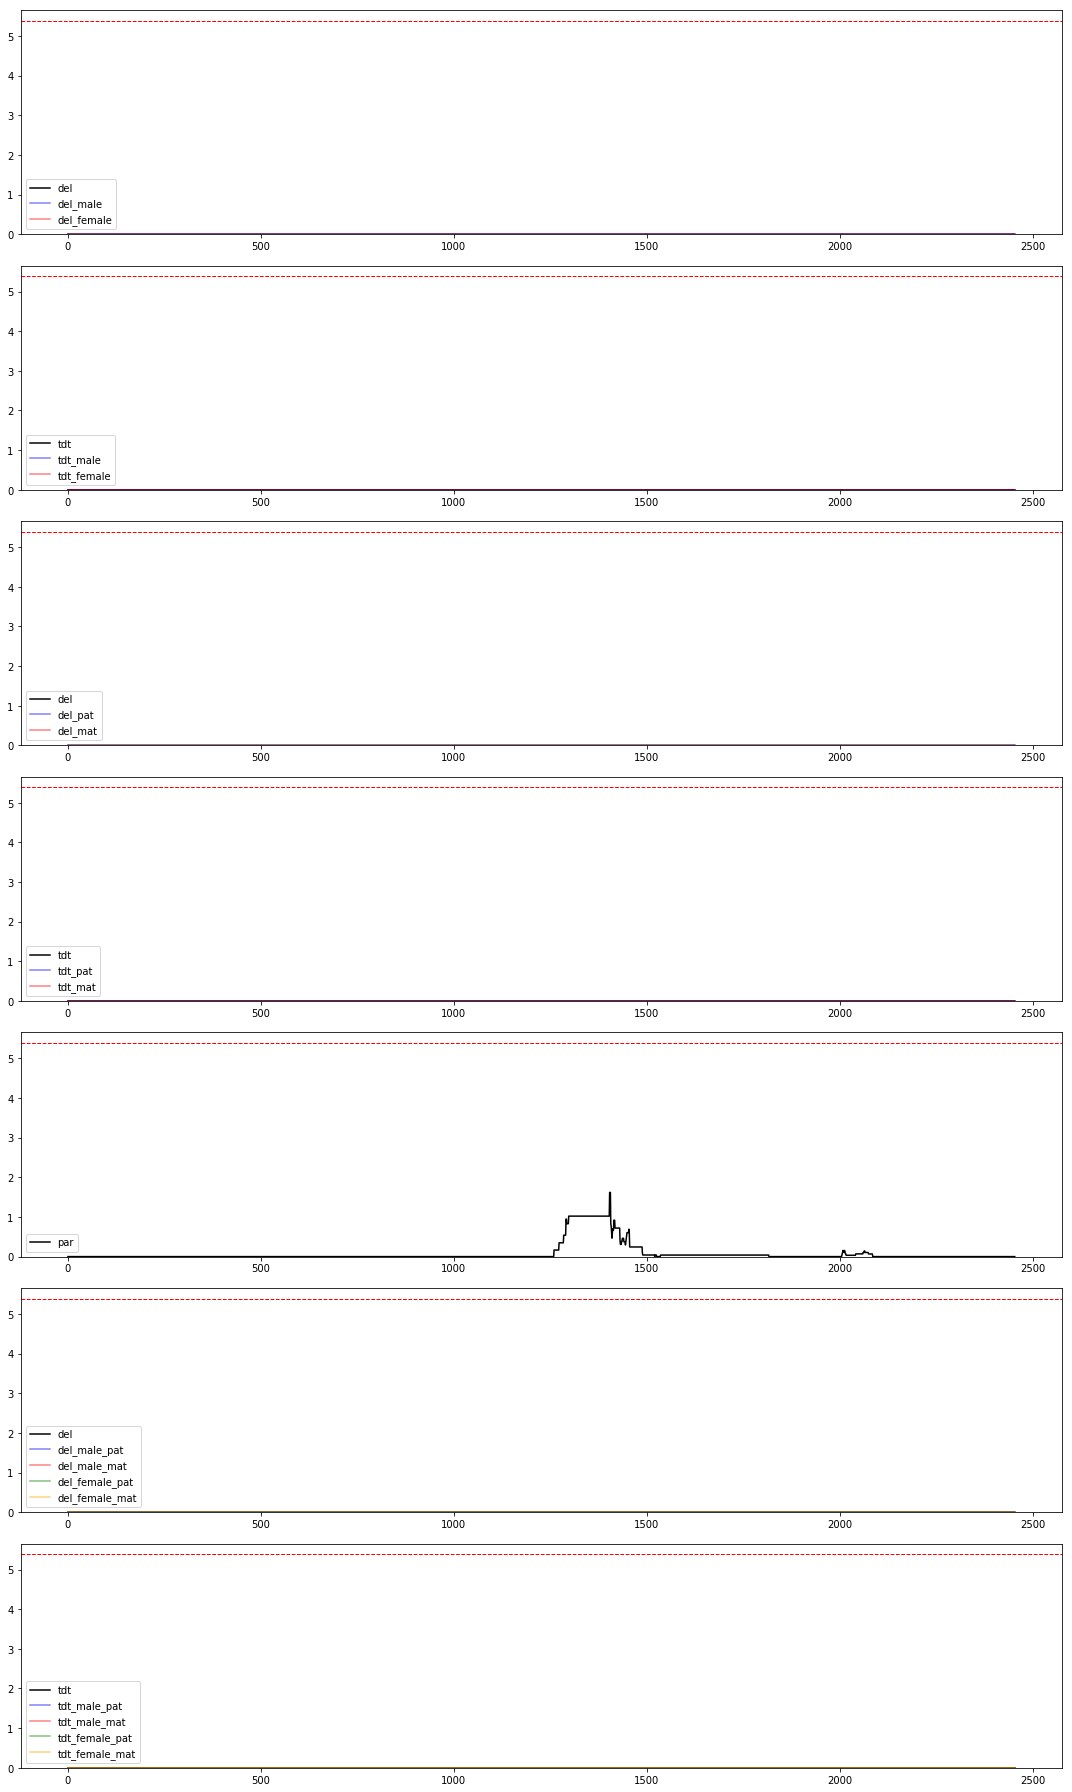

In [966]:
import matplotlib.pyplot as plt

def print_peaks(pvalues, label, comp=None):
    p = -np.log10(pvalues)
    cutoff = -np.log10(0.01/num_tests)
    hit_start_indices = np.where((p[:-1] < cutoff) & (p[1:] >= cutoff))[0]
    hit_end_indices = np.where((p[:-1] >= cutoff) & (p[1:] < cutoff))[0]
    peaks = []
    for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
        hit_start, hit_end = indices[hit_start], indices[hit_end]
        start_pos, end_pos = int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1])
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        peak = (int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]))
        peaks.append(peak)
        star = '*' if comp is not None and peak in comp else ''            
        print(star + label, end_pos-start_pos, start_pos, end_pos, xticklabels[cyto], sep='\t')
    return set(peaks)
np.set_printoptions(suppress=True)

# plot pvalues
plt.figure(figsize=(15, 25))

to_plot = [('del_pvalues', 'del_male_pvalues', 'del_female_pvalues'),
          ('tdt_pvalues', 'tdt_male_pvalues', 'tdt_female_pvalues'),
          ('del_pvalues', 'del_pat_pvalues', 'del_mat_pvalues'),
          ('tdt_pvalues', 'tdt_pat_pvalues', 'tdt_mat_pvalues'),
          ('par_pvalues',),
          ('del_pvalues', 'del_male_pat_pvalues', 'del_male_mat_pvalues', 'del_female_pat_pvalues', 'del_female_mat_pvalues'),
          ('tdt_pvalues', 'tdt_male_pat_pvalues', 'tdt_male_mat_pvalues', 'tdt_female_pat_pvalues', 'tdt_female_mat_pvalues')
          ]

for i, to_p in enumerate(to_plot):
    plt.subplot(len(to_plot), 1, i+1)
    colors = ['black', 'blue', 'red', 'green', 'orange']
    saved_peaks = None
    for j, p in enumerate(to_p):
        #plt.plot(snp_positions[indices], -np.log10(eval(p)[indices]), label=p[:-8], color=colors[j], alpha=1 if colors[j] == 'black' else 0.5)
        plt.plot(-np.log10(eval(p)[indices]), label=p[:-8], color=colors[j], alpha=1 if colors[j] == 'black' else 0.5)

        pp = print_peaks(eval(p), p[:-8], comp=saved_peaks)
        if saved_peaks is None:
            saved_peaks = pp

    #plt.xticks(xticks, xticklabels, rotation='vertical')
    plt.axhline(y=-np.log10(0.01/num_tests), linewidth=1, linestyle='--', color='r')
    plt.ylim(bottom=0)
    plt.legend()

plt.tight_layout()
plt.show()

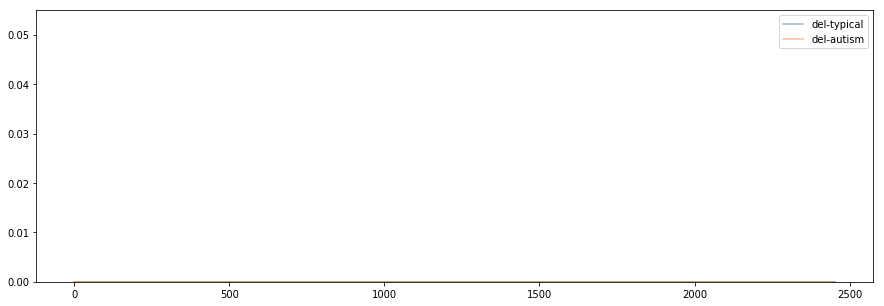

In [967]:
plt.figure(figsize=(15, 5))
s = np.sum(del_conting_t, axis=(3, 4))
#plt.plot(snp_positions[indices], s[indices, 1, 0], label='del-typical', alpha=0.5)
#plt.plot(snp_positions[indices], s[indices, 1, 1], label='del-autism', alpha=0.5)
plt.plot(s[indices, 1, 0], label='del-typical', alpha=0.5)
plt.plot(s[indices, 1, 1], label='del-autism', alpha=0.5)

#plt.xticks(xticks, xticklabels, rotation='vertical')
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [17]:
p = -np.log10(tdt_pvalues[indices])
cutoff = 3
hit_start_indices = np.where((p[:-1] < cutoff) & (p[1:] >= cutoff))[0]
hit_end_indices = np.where((p[:-1] >= cutoff) & (p[1:] < cutoff))[0]
for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    hit_start, hit_end = indices[hit_start], indices[hit_end]
    start_pos, end_pos = int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1])
    cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
               
    print(end_pos-start_pos, start_pos, end_pos, xticklabels[cyto], sep='\t')
    
print(np.min(tdt_pvalues))

212	24344336	24344548	q11.23
25336	24369964	24395300	q11.23
0.0004984569533318851


# Pull in other SV callers

In [16]:
sv_deletions = np.zeros((snp_positions.shape[0],), dtype=int)
with open('../other_sv_calls/Consensus_structural_calls/iHART_ms1.common_DEL_SMuFin-LUMPY-GenomeSTRiP-BreakDancer.1percent.2ormoreMethods.sorted.union.txt') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if chrom == pieces[0]:
            start_index = np.searchsorted(snp_positions, int(pieces[1]))
            end_index = np.searchsorted(snp_positions, int(pieces[2]))
            sv_deletions[start_index:end_index] += 1
    
    

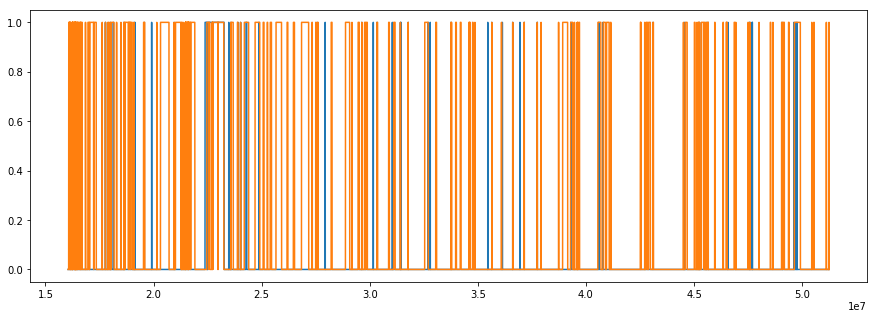

In [29]:
has_deletions = np.sum(del_conting_t[:-1, 1, :, :, :], axis=(1, 2, 3))>0
plt.figure(figsize=(15, 5))
plt.plot(snp_positions, sv_deletions)
plt.plot(snp_positions, has_deletions)
plt.show()

In [33]:
print(np.sum((sv_deletions==1) & (has_deletions==1)))
print(np.sum((sv_deletions==1) & (has_deletions==0)))
print(np.sum((sv_deletions==0) & (has_deletions==1)))
print(np.sum((sv_deletions==0) & (has_deletions==0)))

28543
10056
175517
790533


# Let's consider missing deletions
We won't be able to detect a deletion if it isn't inherited. So what fraction of the genome isn't inherited?

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


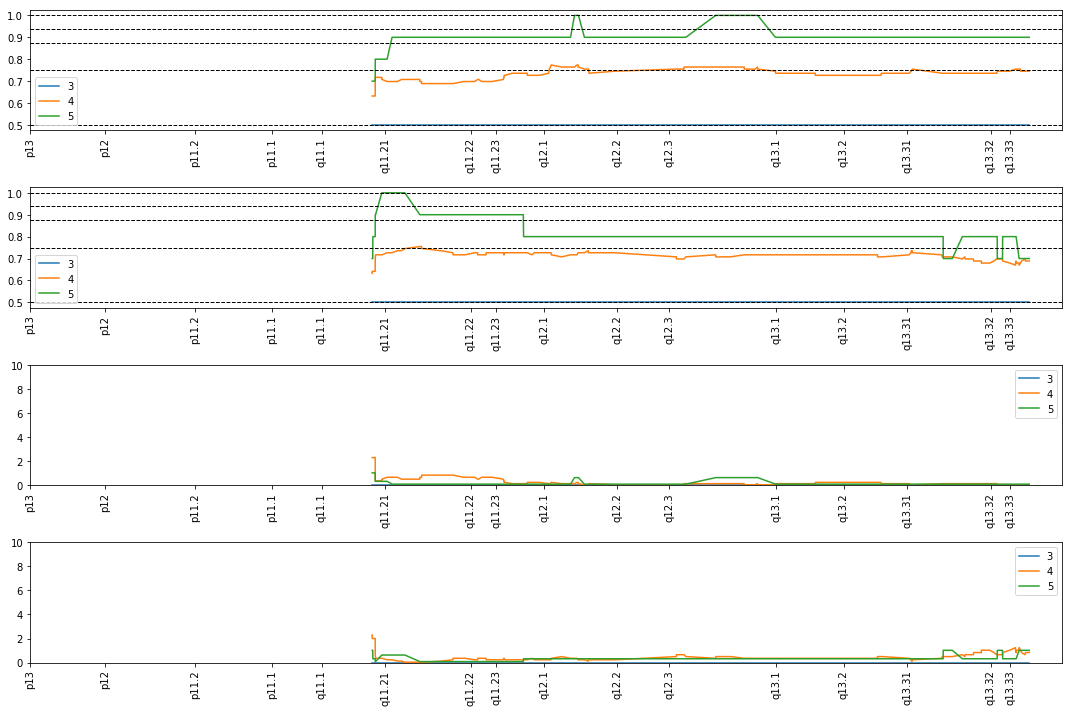

In [77]:
from scipy.stats import chisquare

plt.figure(figsize=(15, 10))
inh_ps = [0]*(max(family_sizes)+1)
inh_mat_ps = [0]*(max(family_sizes)+1)
inh_pat_ps = [0]*(max(family_sizes)+1)

for j in family_sizes:
    inherited = np.zeros((max_index+1,2), dtype=int)
    not_inherited = np.zeros((max_index+1,2), dtype=int)

    with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = list(map(int, pieces[1:(1+(j*2))]))
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
                            
            m1_inh, m2_inh, p1_inh, p2_inh = 0, 0, 0, 0
            for k, s in enumerate(inheritance_state[4:]):
                if k % 2 == 0:
                    m1_inh += (s==0)
                    m2_inh += (s==1)
                else:
                    p1_inh += (s==0)
                    p2_inh += (s==1)
                        
            num_mat_inherited, num_pat_inherited = (m1_inh>0) + (m2_inh>0), (p1_inh>0) + (p2_inh>0)
            inherited[start_index:(end_index+1), 0] += num_mat_inherited
            inherited[start_index:(end_index+1), 1] += num_pat_inherited
            not_inherited[start_index:(end_index+1), 0] += 2 - num_mat_inherited
            not_inherited[start_index:(end_index+1), 1] += 2 - num_pat_inherited

        plt.subplot(4, 1, 1)
        plt.plot(snp_positions[indices], (inherited[:, 0]/(inherited[:, 0]+not_inherited[:, 0]))[indices], label=str(j))
        plt.subplot(4, 1, 2)
        plt.plot(snp_positions[indices], (inherited[:, 1]/(inherited[:, 1]+not_inherited[:, 1]))[indices], label=str(j))
        
        # calc pvalues
        inh_ps[j] = np.ones((max_index+1,))
        inh_mat_ps[j] = np.ones((max_index+1,))
        inh_pat_ps[j] = np.ones((max_index+1,))
        for i in indices:
            p_not_inherited = pow(0.5, j-2)
            inh, notinh = inherited[i, 0], not_inherited[i, 0]
            total = inh+notinh
            inh_mat_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
            
            inh, notinh = inherited[i, 1], not_inherited[i, 1]
            total = inh+notinh
            inh_pat_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
            
            inh, notinh = inherited[i, 0]+inherited[i, 1], not_inherited[i, 0]+not_inherited[i, 1]
            total = inh+notinh
            inh_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
        
        
        plt.subplot(4, 1, 3)
        plt.plot(snp_positions[indices], -np.log10(inh_mat_ps[j][indices]), label=str(j))
        
        plt.subplot(4, 1, 4)
        plt.plot(snp_positions[indices], -np.log10(inh_pat_ps[j][indices]), label=str(j))
        
plt.subplot(4, 1, 1)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.75, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.875, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.9375, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.75, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.875, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.9375, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(4, 1, 3)
plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.ylim(0, 10)
plt.legend()

plt.subplot(4, 1, 4)
plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.ylim(0, 10)
plt.legend()

plt.tight_layout()
plt.show()

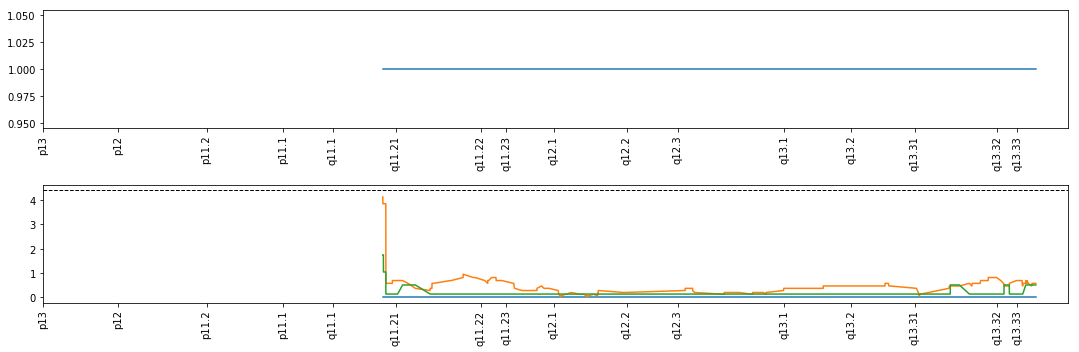

In [78]:
plt.figure(figsize=(15, 5))
# only look at regions where inheritance rate is close to expected
ok_indices = np.ones((max_index+1,), dtype=bool)
plt.subplot(2, 1, 2)
for j in family_sizes:
    ok_indices[-np.log10(inh_ps[j]) > -np.log10(0.01/indices.shape[0])] = 0
    plt.plot(snp_positions[indices], -np.log10(inh_ps[j][indices]))
ok_indices[-np.log10(par_pvalues) > -np.log10(0.01/indices.shape[0])] = 0
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='black')

plt.subplot(2, 1, 1)
plt.plot(snp_positions[indices], ok_indices[indices])
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.tight_layout()
plt.show()

# Check for outliers

In [79]:
next_state = [0, 0, 0, 0]
starts = [max_index+1, max_index+1, max_index+1, max_index+1]
del_start = np.zeros((max_index,))
del_end = np.zeros((max_index,))
del_intervals = []
prev_key = None
for j in family_sizes:      
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1
            
            if len([x for x in inheritance_state[:4] if x is None]) == 0:
                if prev_key != family_key:
                    next_state = inheritance_state[:4]
                    starts = [max_index+1, max_index+1, max_index+1, max_index+1]
                    prev_key = family_key
                
                for i in range(4):
                    if inheritance_state[i] == 0 and next_state[i] == 1:
                        del_start[end_index:starts[i]] += 1
                        del_intervals.append(snp_positions[starts[i]]-snp_positions[end_index])
                       # print('start', end_index, starts[i], starts[i]-end_index)

                    elif inheritance_state[i] == 1 and next_state[i] == 0:
                        del_end[end_index:starts[i]] += 1
                        del_intervals.append(snp_positions[starts[i]]-snp_positions[end_index])
                        #print('end', end_index, starts[i], starts[i]-end_index)

                    starts[i] = start_index
                    next_state[i] = inheritance_state[i]

In [80]:
import math

print(np.median([x for x in del_intervals if x != 1]))

plt.figure(figsize=(20, 5))
base = 1.4
max_length = max(del_intervals) 
min_length = min(del_intervals) 
print('min length', min_length, 'max length', max_length, 'num', len(del_intervals))
plt.hist(del_intervals, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.gca().set_xscale("log")
plt.show()

nan


//anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: max() arg is an empty sequence

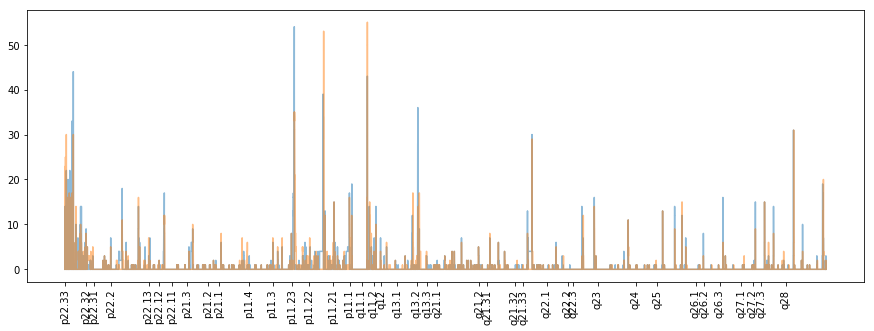

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(snp_positions, del_start, alpha=0.5)
plt.plot(snp_positions, del_end, alpha=0.5)
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.show()

outliers 0
[]


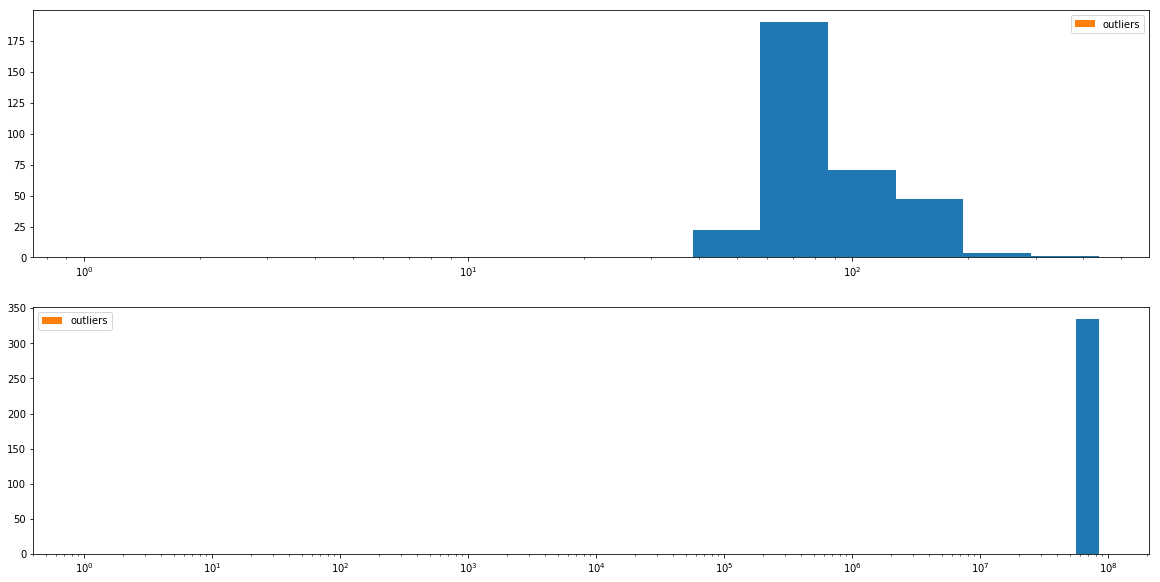

In [323]:
import math

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# deletions per family
plt.figure(figsize=(20, 10))

family_to_num_deletions = defaultdict(int)
family_to_nucleo_deleted = defaultdict(int)

for d in deletions:
    family_to_num_deletions[d.family] += 1
    family_to_nucleo_deleted[d.family] += d.length
    
outliers = [f for f in family_to_num_deletions.keys() if family_to_num_deletions[f] > 10000]
print('outliers', len(outliers))
print([(f, len(family_to_individuals[f])) for f in outliers])

base = 1.5

plt.subplot(2, 1, 1)
max_length = max(family_to_num_deletions.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_num_deletions.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_num_deletions.items() if f in outliers], bins=bins, label='outliers')
plt.gca().set_xscale("log")
plt.legend()

plt.subplot(2, 1, 2)
max_length = max(family_to_nucleo_deleted.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f in outliers], bins=bins, label='outliers')

plt.gca().set_xscale("log")
plt.legend()

#ax3 = plt.subplot(3, 1, 3)
#min_family = min(family_to_num_deletions.items(), key=lambda x:x[1])[0]
#max_family = max(family_to_num_deletions.items(), key=lambda x:x[1])[0]

#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==min_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='blue')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)
#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==max_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='red')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)

#plt.plot(sum([[d.start_pos, d.end_pos] for d in min_family_dels]), sum([[]]))
#plt.legend()
plt.show()

# Distribution of deletions

51304566
min length 1437 max length 957220653 num 242 num/family 3.408450704225352


<Figure size 1440x360 with 0 Axes>

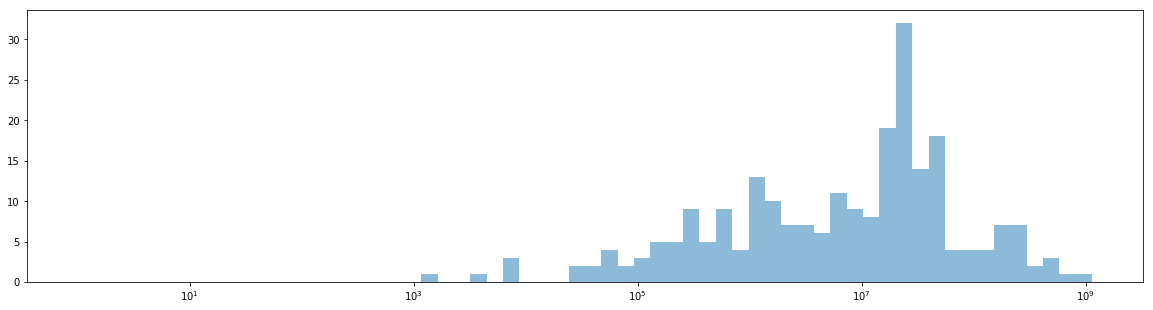

In [81]:
import math

d_length = [0, 0, 0, 0]
d_intervals = []
for j in family_sizes:
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1

            for i in range(4):
                if inheritance_state[i] == 1:
                    d_length[i] += length
                elif d_length[i] != 0:
                    d_intervals.append(d_length[i])
                    d_length[i] = 0
for i in range(4):
    if d_length[i] != 0:
        d_intervals.append(d_length[i])
    

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max(d_intervals) 
min_length = min(d_intervals) 
print(snp_positions[-1])
print('min length', min_length, 'max length', max_length, 'num', len(d_intervals), 'num/family', len(d_intervals)/len(family_to_individuals))
plt.hist(d_intervals, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.gca().set_xscale("log")
plt.show()

min length 0 max length 2844709


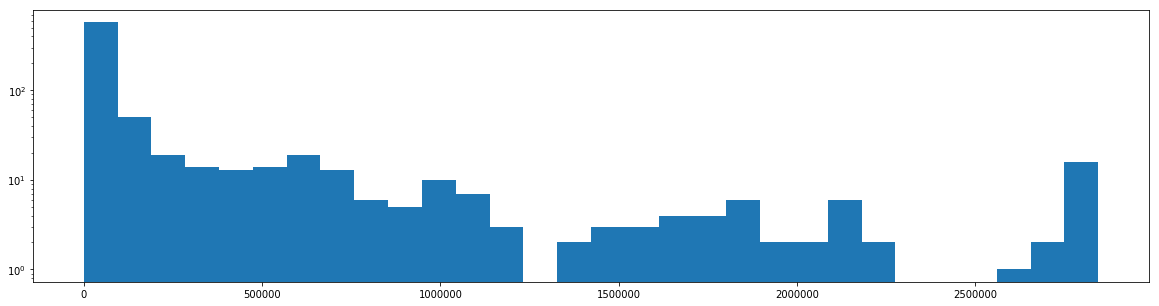

In [82]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.end_index-d.start_index for d in deletions]) 
min_length = min([d.end_index-d.start_index for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.end_index-d.start_index for d in deletions], bins=30, log=True)#, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
#plt.gca().set_xscale("log")
plt.show()